In [3]:
### soc-sign-bitcoinotc_v2.csv is modified version of data with UTC timestamp (in string)

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import ipywidgets as wg
from IPython.display import display

In [11]:
### unix to utc -> df['#timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

def sort_dict(dict_, reverse=True, values=False, top=None):
    """
    Sort a deictionary 
    params
     - dict_ : dictionary to be sorted
     - reverse: True if descending
     - values: returns just the values (not the keys)
     - top: return first top elements , if None return all
    """
    sorted_ = sorted(dict_.items(), key=lambda x: x[1], reverse=reverse)
    if top:
        sorted_ =  sorted_[:top]
    if values:
        return [x[1] for x in sorted_]
    return dict(sorted_)
    

def counter(list_, top = None):
    """
    Get the distribution of entries in list
    """
    count_list = Counter(list_)
    if top:
        dict(count_list.most_common(top))
    return count_list

def plot_hist(list_, fig_size=(20,10), ax=None, x_scale='linear', y_scale='linear'):
    if not ax:
        fig, ax = plt.subplots(figsize=fig_size)
    plt_ = sns.histplot(list_, ax=ax)
    plt_.axes.set_xscale(x_scale)
    plt_.axes.set_yscale(y_scale)

def str_to_date(date, format_='%Y-%m-%d %H:%M:%S'):
    """
    sting to utc timestamp
    """
    return datetime.strptime(date, format_)

def get_ratings(graph, node, to_datetime=False):
    """
    For a given user(node) get all the attributes of incoming liks and out going links
    
    return: in_rating_list: list of attributes of all incoming links to node
            out_rating_list: list of attributes of all outgoing links to node
    """
    in_rating_list = []
    out_rating_list = []
    for neighbor in set(nx.all_neighbors(graph, node)):
        attr_in = graph.get_edge_data(neighbor, node)
        attr_out = graph.get_edge_data(node, neighbor)
        if attr_in:
            attr_in = attr_in.copy()
            if to_datetime: attr_in['time'] = str_to_date(attr_in['time'])
            in_rating_list.append((neighbor,attr_in))
        if attr_out:
            attr_out = attr_out.copy()
            if to_datetime: attr_out['time'] = str_to_date(attr_out['time'])
            out_rating_list.append((neighbor,attr_out))
    return in_rating_list, out_rating_list

In [94]:
!head -n 5 soc-sign-bitcoinotc_v2.csv

#source,#target,#rating,#timestamp
6,2,4,2010-11-08 18:45:11
6,5,2,2010-11-08 18:45:41
1,15,1,2010-11-08 19:05:40
4,3,7,2010-11-08 19:41:17


In [4]:
## Is it a multiDiGraph?

G = nx.read_edgelist('soc-sign-bitcoinotc_v2.csv', delimiter=',', nodetype=int,
                     data = (('rating', int), ('time', str)), 
                     create_using=nx.MultiDiGraph)

"""
The maximum number of edges between two nodes is 1, hence the graph is a DiGraph
"""
Counter(G.edges()).most_common(2) 

[((6, 2), 1), ((6, 5), 1)]

In [5]:
G = nx.read_edgelist('soc-sign-bitcoinotc_v2.csv', delimiter=',', nodetype=int,
                     data = (('rating', int), ('time', str)), 
                     create_using=nx.DiGraph)

In [6]:
print("Number of users: ", nx.number_of_nodes(G))
print('Number of ratings', nx.number_of_edges(G))

Number of users:  5881
Number of ratings 35592


### Plotting a sub graph

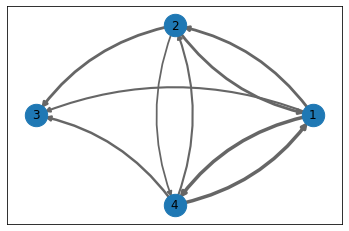

In [9]:
G_sub = nx.subgraph(G, [1,2,3,4])
pos = nx.circular_layout(G_sub)
edge_label = nx.get_edge_attributes(G_sub,'rating')
edge_weight = [0.35*G_sub[u][v]['rating'] for u,v in G_sub.edges()]
nx.draw_networkx_nodes(G_sub, pos, node_size=500)
nx.draw_networkx_labels(G_sub, pos)
_ = nx.draw_networkx_edges(G_sub, pos, connectionstyle='arc3, rad = 0.2', width=edge_weight, edge_color='.4', label=edge_label)
#_ = nx.draw_networkx_edges(G_sub, pos, edge_labels = edge_label, font_size=8)


### Degree centrality distribution
- Most of the users have made fewer transaction and half of the users with less than or equal to 4 transcation

80 percent of users have rated less than 5 users


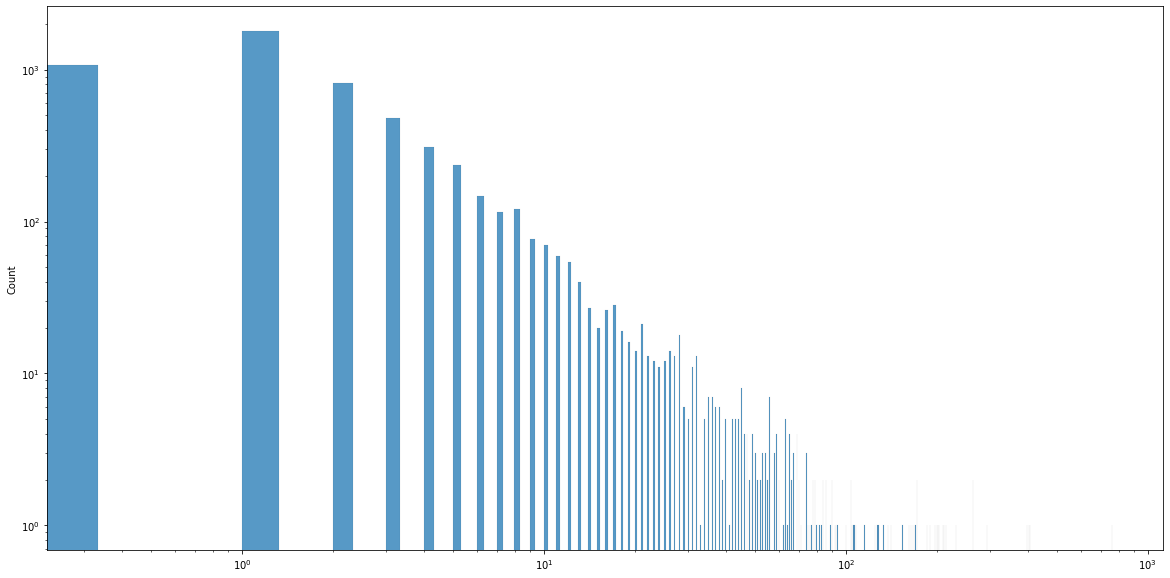

In [12]:
out_degree = dict(G.out_degree())
out_deg_scores = sort_dict(out_degree, values=True)
print(f'80 percent of users have rated less than {int(np.percentile(out_deg_scores, 80))} users')
plot_hist(out_deg_scores, x_scale='log', y_scale='log')

### 20 percent of users consitute 80 percent of ratings
### 18 percent of users never rated any other users

0.1814317292977385


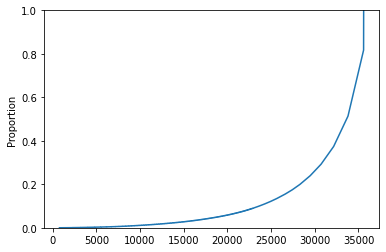

In [13]:
cum_sum_out_deg = np.cumsum(out_deg_scores)
cum_sum_out_deg = cum_sum_out_deg[cum_sum_out_deg>0]
sns.ecdfplot(cum_sum_out_deg)
print(np.mean(np.array(out_deg_scores)==0))

### Rating distribution
- Half of the rating are less than or equal to 1
- Less than 10 percent of ratings are greater than equal to 4

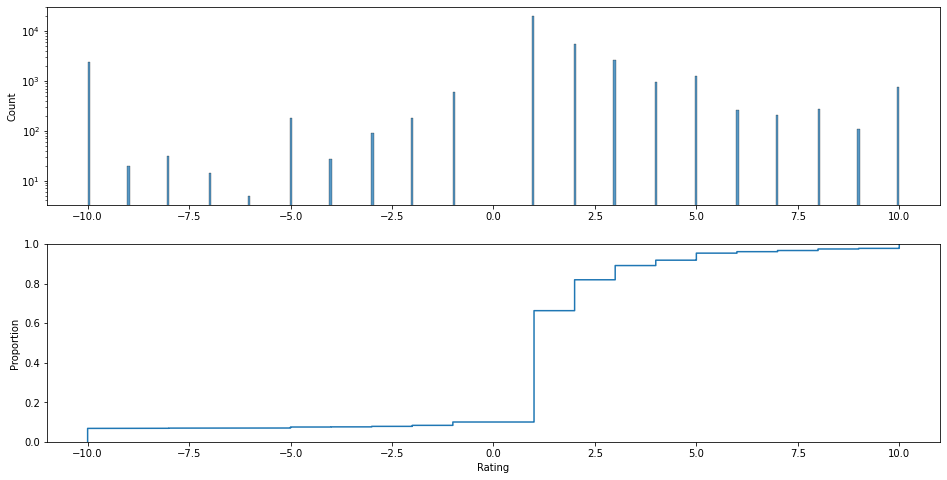

In [14]:
fig, axes = plt.subplots(2,1, figsize=(16,8))
ratings = [G.get_edge_data(*edge)['rating'] for edge in G.edges()]
plot_hist(ratings, fig_size=(10,8), y_scale='log', ax=axes[0])

sns.ecdfplot(ratings, ax=axes[1])
_ = axes[1].set_xlabel('Rating')

### Around 80 percent of users are part of strongly connected component

In [15]:
scc = [node_set for node_set in nx.strongly_connected_components(G)]
scc_count = [len(node_set) for node_set in scc]
scc_node_counter = Counter(scc_count).most_common(5)

print('The number of nodes in largest component is ', scc_node_counter[-1][0])

The number of nodes in largest component is  4709


In [16]:
in_deg = [deg for node, deg in dict(G.in_degree()).items()]
out_deg = [deg for node, deg in dict(G.out_degree()).items()]

#### There is a positive correlation between number of users rated by the user and number of ratings received by him.

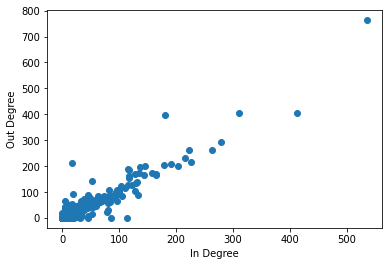

In [17]:
plt.scatter(in_deg, out_deg)
plt.xlabel('In Degree')
_ = plt.ylabel('Out Degree')

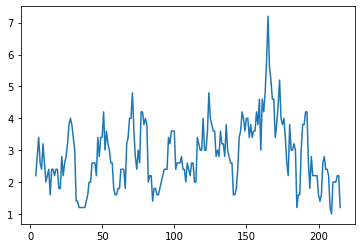

In [18]:
in_ , out_ = get_ratings(G, 7, True)
in_ = sorted(in_, key=lambda x:x[1]['time'] )
in_rating = [x[1]['rating'] for x in in_]
plt.plot(pd.Series(in_rating).rolling(window=5).mean())
#sort_dict(dict(G.degree()))